# Place Field Analysis

This notebook demonstrates how to detect and analyze place fields using the neurospatial metrics module.

**What you'll learn:**
- Detecting place fields from firing rate maps
- Computing single-cell spatial metrics (Skaggs information, sparsity)
- Computing field properties (size, centroid)
- Visualizing place fields on environments

**Time:** ~15 minutes

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Neurospatial imports
from neurospatial import Environment, compute_place_field
from neurospatial.metrics import (
    detect_place_fields,
    field_centroid,
    field_size,
    field_stability,
    skaggs_information,
    sparsity,
)

# Set random seed for reproducibility
np.random.seed(42)

## Part 1: Generate Synthetic Data

We'll create a synthetic trajectory with a place cell that has:
- A single place field in the environment
- Peak firing rate of ~10 Hz
- Gaussian spatial tuning

In [2]:
# Generate 2D random walk in open field arena
sampling_rate = 50.0  # Hz
duration = 100.0  # seconds
n_samples = int(duration * sampling_rate)
times = np.linspace(0, duration, n_samples)

# Arena size: 100x100 cm open field
arena_size = 100.0  # cm
arena_center = arena_size / 2

# Random walk parameters
step_size = 2.0  # cm per step
boundary_margin = 5.0  # cm from walls

# Initialize trajectory
positions = np.zeros((n_samples, 2))
positions[0] = [arena_center, arena_center]  # Start at center

# Generate random walk with wall reflection
for i in range(1, n_samples):
    # Random step direction
    angle = np.random.uniform(0, 2 * np.pi)
    step = step_size * np.array([np.cos(angle), np.sin(angle)])

    # Propose new position
    new_pos = positions[i - 1] + step

    # Reflect at boundaries (with margin)
    for dim in range(2):
        if new_pos[dim] < boundary_margin:
            new_pos[dim] = boundary_margin + (boundary_margin - new_pos[dim])
        elif new_pos[dim] > (arena_size - boundary_margin):
            new_pos[dim] = (arena_size - boundary_margin) - (
                new_pos[dim] - (arena_size - boundary_margin)
            )

    positions[i] = new_pos

# Create environment
env = Environment.from_samples(
    positions,
    bin_size=3.0,
    bin_count_threshold=5,
)
env.units = "cm"
env.frame = "open_field"

print(f"Environment: {arena_size:.0f}x{arena_size:.0f} cm open field")
print(f"  {env.n_bins} bins, {env.n_dims}D")
print(
    f"  Coverage: x=[{positions[:, 0].min():.1f}, {positions[:, 0].max():.1f}], y=[{positions[:, 1].min():.1f}, {positions[:, 1].max():.1f}] cm"
)

Environment: 100x100 cm open field
  331 bins, 2D
  Coverage: x=[10.8, 95.0], y=[5.0, 95.0] cm


### Define Place Cell Properties

We'll create a place cell with a Gaussian place field:
- Field center at (60, 50) cm
- Spatial tuning width σ = 10 cm
- Peak firing rate = 10 Hz

In [3]:
# Place field center
field_center = np.array([60.0, 50.0])

# Generate spikes based on Gaussian place field
sigma = 10.0  # Spatial tuning width (cm)
peak_rate = 10.0  # Hz

# Compute firing probability at each position
distances_to_field = np.linalg.norm(positions - field_center, axis=1)
firing_rate_at_position = peak_rate * np.exp(-(distances_to_field**2) / (2 * sigma**2))

# Generate spike times (Poisson process)
dt = np.mean(np.diff(times))
spike_probs = firing_rate_at_position * dt
spike_mask = np.random.rand(n_samples) < spike_probs
spike_times = times[spike_mask]

print(f"Generated {len(spike_times)} spikes")
print(f"Mean firing rate: {len(spike_times) / times[-1]:.2f} Hz")

Generated 158 spikes
Mean firing rate: 1.58 Hz


## Part 2: Compute Firing Rate Map

Convert spike train to a spatial firing rate map using occupancy normalization.

Firing rate range: [0.00, 8.68] Hz
Mean firing rate: 1.63 Hz


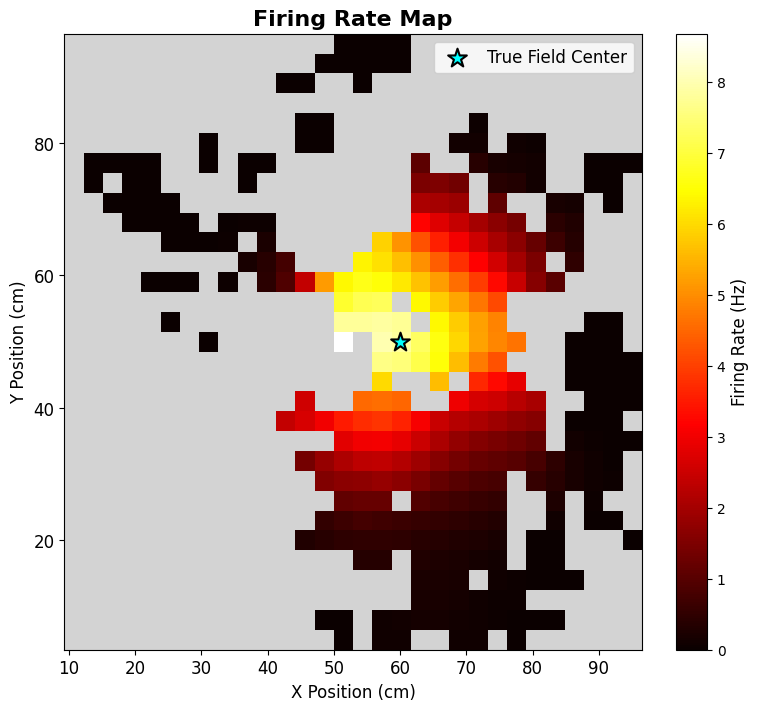

In [4]:
# Compute occupancy-normalized firing rate with smoothing
# Using diffusion KDE method (default) with 5 cm bandwidth
# This method spreads spike and occupancy mass BEFORE normalization
# and respects environment boundaries via graph connectivity
firing_rate = compute_place_field(
    env,
    spike_times,
    times,
    positions,
    method="diffusion_kde",  # Default: boundary-aware graph-based KDE
    bandwidth=5.0,  # Spatial smoothing bandwidth (cm)
)

print(
    f"Firing rate range: [{np.nanmin(firing_rate):.2f}, {np.nanmax(firing_rate):.2f}] Hz"
)
print(f"Mean firing rate: {np.nanmean(firing_rate[~np.isnan(firing_rate)]):.2f} Hz")

# Visualize firing rate map using plot_field()
fig, ax = plt.subplots(figsize=(8, 7), constrained_layout=True)

# Plot firing rate with env.plot_field()
env.plot_field(
    firing_rate,
    ax=ax,
    cmap="hot",
    vmin=0,
    colorbar_label="Firing Rate (Hz)",
)

# Add field center marker
ax.scatter(
    field_center[0],
    field_center[1],
    s=200,
    c="cyan",
    marker="*",
    edgecolors="black",
    linewidths=1.5,
    label="True Field Center",
    zorder=10,
)

ax.set_title("Firing Rate Map", fontsize=16, fontweight="bold")
ax.legend(fontsize=12)
ax.tick_params(labelsize=12)

plt.show()

## Part 3: Detect Place Fields

Use the `detect_place_fields()` function to automatically identify place fields.

The algorithm:
1. Finds peaks in the firing rate map
2. Segments regions above 20% of peak rate
3. Uses graph connectivity to extract contiguous fields
4. Optionally detects subfields (coalescent fields)

In [5]:
# Detect place fields
place_fields = detect_place_fields(
    firing_rate,
    env,
    threshold=0.2,  # Segment at 20% of peak rate
    min_size=None,  # No minimum size (auto: 9 bins)
    max_mean_rate=10.0,  # Exclude interneurons (>10 Hz mean rate)
    detect_subfields=True,  # Detect coalescent subfields
)

print(f"Detected {len(place_fields)} place field(s)")

for i, field_bins in enumerate(place_fields):
    print(f"\nField {i + 1}:")
    print(f"  Number of bins: {len(field_bins)}")
    print(f"  Peak rate: {np.max(firing_rate[field_bins]):.2f} Hz")
    print(f"  Mean rate in field: {np.mean(firing_rate[field_bins]):.2f} Hz")

Detected 1 place field(s)

Field 1:
  Number of bins: 107
  Peak rate: 8.68 Hz
  Mean rate in field: 4.31 Hz


### Visualize Detected Place Fields

Show the detected place fields overlaid on the firing rate map.

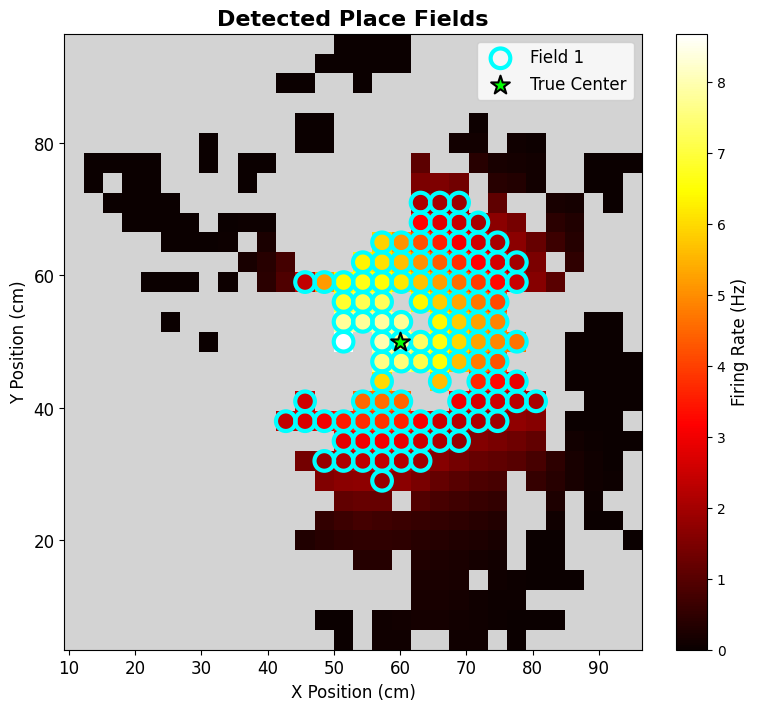

In [6]:
fig, ax = plt.subplots(figsize=(8, 7), constrained_layout=True)

# Plot firing rate (background) using plot_field()
env.plot_field(
    firing_rate,
    ax=ax,
    cmap="hot",
    vmin=0,
    colorbar_label="Firing Rate (Hz)",
)

# Plot detected place field bins
if len(place_fields) > 0:
    for i, field_bins in enumerate(place_fields):
        ax.scatter(
            env.bin_centers[field_bins, 0],
            env.bin_centers[field_bins, 1],
            s=200,
            facecolors="none",
            edgecolors="cyan",
            linewidths=3,
            label=f"Field {i + 1}" if i == 0 else "",
        )

# Add true field center
ax.scatter(
    field_center[0],
    field_center[1],
    s=200,
    c="lime",
    marker="*",
    edgecolors="black",
    linewidths=1.5,
    label="True Center",
    zorder=10,
)

ax.set_title("Detected Place Fields", fontsize=16, fontweight="bold")
ax.legend(fontsize=12)
ax.tick_params(labelsize=12)

plt.show()

## Part 4: Compute Field Properties

For each detected field, compute:
- Field size (area in cm²)
- Field centroid (center of mass, weighted by firing rate)

In [7]:
# Compute field properties
for i, field_bins in enumerate(place_fields):
    # Field size (area in physical units)
    area = field_size(field_bins, env)

    # Field centroid (center of mass)
    centroid = field_centroid(firing_rate, field_bins, env)

    # Distance from true center
    distance_from_true = np.linalg.norm(centroid - field_center)

    print(f"\nField {i + 1} Properties:")
    print(f"  Area: {area:.1f} cm²")
    print(f"  Centroid: ({centroid[0]:.1f}, {centroid[1]:.1f}) cm")
    print(f"  Distance from true center: {distance_from_true:.1f} cm")


Field 1 Properties:
  Area: 932.4 cm²
  Centroid: (62.4, 51.5) cm
  Distance from true center: 2.8 cm


## Part 5: Compute Single-Cell Spatial Metrics

Compute standard neuroscience metrics that quantify spatial coding quality:

**Skaggs Spatial Information** (Skaggs et al., 1993)
- Measures how much information (in bits) the firing rate conveys about position
- Typical range: 0-3+ bits/spike
- Higher values = better place cell

**Sparsity** (Skaggs et al., 1996)
- Measures how focally a cell fires in space
- Range: [0, 1], where 0 = fires everywhere, 1 = fires in single location
- Typical place cells: 0.1-0.5

In [8]:
# Compute occupancy for metrics
occupancy = env.occupancy(times, positions, return_seconds=True)

# Skaggs spatial information (bits/spike)
spatial_info = skaggs_information(firing_rate, occupancy, base=2.0)

# Sparsity
sparsity_score = sparsity(firing_rate, occupancy)

print("\nSpatial Coding Metrics:")
print(f"  Skaggs Information: {spatial_info:.3f} bits/spike")
print(f"  Sparsity: {sparsity_score:.3f}")
print("\nInterpretation:")
print(
    f"  - Spatial information > 1.0: Strong spatial coding (this cell: {'YES' if spatial_info > 1.0 else 'NO'})"
)
print(
    f"  - Sparsity > 0.2: Focal firing (this cell: {'YES' if sparsity_score > 0.2 else 'NO'})"
)


Spatial Coding Metrics:
  Skaggs Information: 1.089 bits/spike
  Sparsity: 0.381

Interpretation:
  - Spatial information > 1.0: Strong spatial coding (this cell: YES)
  - Sparsity > 0.2: Focal firing (this cell: YES)


## Part 6: Field Stability

Assess whether the place field is stable across time by splitting the session in half
and computing the correlation between firing rate maps.

High correlation (> 0.7) indicates a stable place field.


Field Stability:
  Pearson correlation: 0.377
  Spearman correlation: 0.394

Interpretation:
  - Correlation > 0.7: Stable field (this cell: NO)


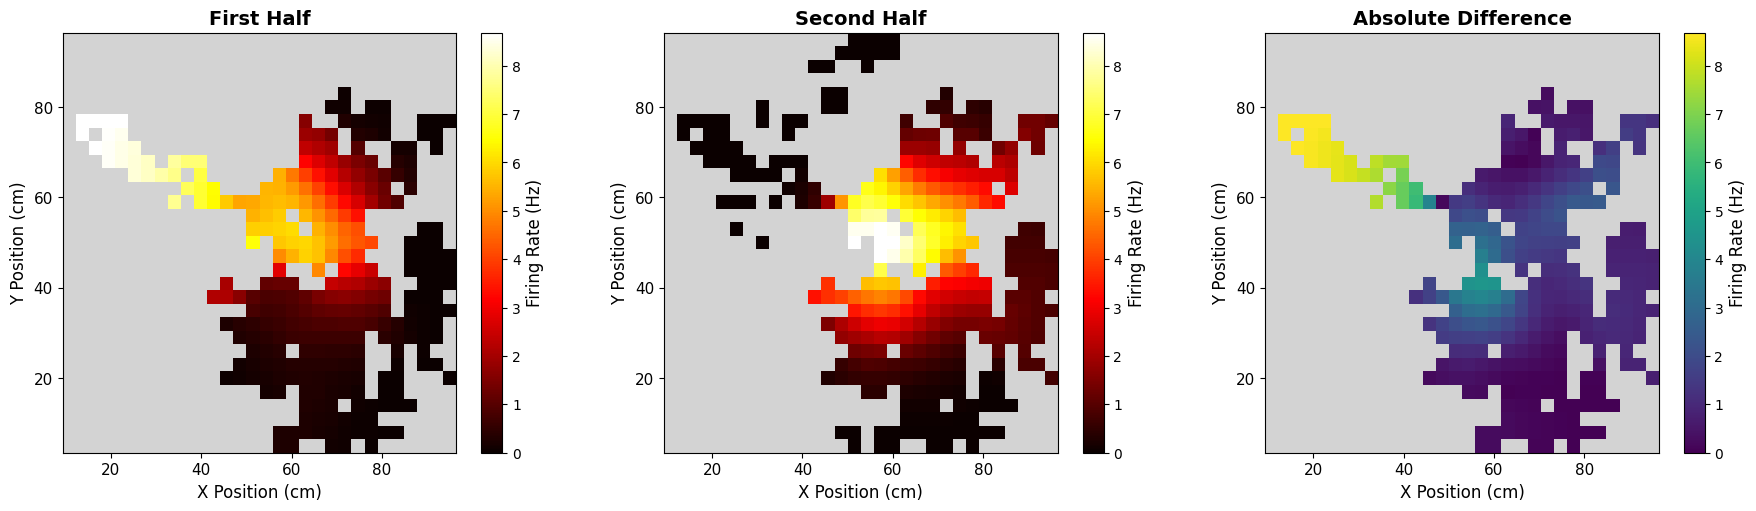

In [9]:
# Split session in half
mid_time = times[len(times) // 2]
first_half_mask = times < mid_time
second_half_mask = times >= mid_time

# Compute firing rates for each half
firing_rate_half1 = compute_place_field(
    env,
    spike_times[spike_times < mid_time],
    times[first_half_mask],
    positions[first_half_mask],
    bandwidth=5.0,
)

firing_rate_half2 = compute_place_field(
    env,
    spike_times[spike_times >= mid_time],
    times[second_half_mask],
    positions[second_half_mask],
    bandwidth=5.0,
)

# Compute stability (correlation between halves)
stability_pearson = field_stability(
    firing_rate_half1, firing_rate_half2, method="pearson"
)
stability_spearman = field_stability(
    firing_rate_half1, firing_rate_half2, method="spearman"
)

print("\nField Stability:")
print(f"  Pearson correlation: {stability_pearson:.3f}")
print(f"  Spearman correlation: {stability_spearman:.3f}")
print("\nInterpretation:")
print(
    f"  - Correlation > 0.7: Stable field (this cell: {'YES' if stability_pearson > 0.7 else 'NO'})"
)

# Visualize both halves
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

for ax, rate_map, title in zip(
    axes,
    [
        firing_rate_half1,
        firing_rate_half2,
        np.abs(firing_rate_half1 - firing_rate_half2),
    ],
    ["First Half", "Second Half", "Absolute Difference"],
    strict=True,
):
    env.plot_field(
        rate_map,
        ax=ax,
        cmap="hot" if "Difference" not in title else "viridis",
        vmin=0,
        vmax=np.nanmax(firing_rate),
        colorbar_label="Firing Rate (Hz)",
    )

    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.tick_params(labelsize=11)

plt.show()

## Part 7: Complete Workflow Summary

Here's a complete example of the typical place field analysis workflow:

In [10]:
def analyze_place_cell(env, spike_times, times, positions):
    """
    Complete place field analysis workflow.

    Parameters
    ----------
    env : Environment
        Spatial environment
    spike_times : ndarray
        Spike times (seconds)
    times : ndarray
        Trajectory time points (seconds)
    positions : ndarray
        Trajectory positions (N × D)

    Returns
    -------
    results : dict
        Dictionary containing all metrics and detected fields
    """
    # Step 1: Compute firing rate map
    firing_rate = compute_place_field(
        env,
        spike_times,
        times,
        positions,
        bandwidth=5.0,
    )

    # Step 2: Detect place fields
    place_fields = detect_place_fields(
        firing_rate,
        env,
        threshold=0.2,
        max_mean_rate=10.0,
        detect_subfields=True,
    )

    # Step 3: Compute field properties
    field_properties = []
    for field_bins in place_fields:
        field_properties.append(
            {
                "area": field_size(field_bins, env),
                "centroid": field_centroid(firing_rate, field_bins, env),
                "peak_rate": np.max(firing_rate[field_bins]),
                "mean_rate": np.mean(firing_rate[field_bins]),
            }
        )

    # Step 4: Compute spatial metrics
    occupancy = env.occupancy(times, positions, return_seconds=True)
    spatial_info = skaggs_information(firing_rate, occupancy, base=2.0)
    sparsity_score = sparsity(firing_rate, occupancy)

    # Step 5: Assess stability (split-half)
    mid_time = times[len(times) // 2]
    first_half = times < mid_time
    second_half = times >= mid_time

    rate_half1 = compute_place_field(
        env,
        spike_times[spike_times < mid_time],
        times[first_half],
        positions[first_half],
        bandwidth=5.0,
    )

    rate_half2 = compute_place_field(
        env,
        spike_times[spike_times >= mid_time],
        times[second_half],
        positions[second_half],
        bandwidth=5.0,
    )

    stability = field_stability(rate_half1, rate_half2, method="pearson")

    return {
        "firing_rate": firing_rate,
        "place_fields": place_fields,
        "field_properties": field_properties,
        "spatial_information": spatial_info,
        "sparsity": sparsity_score,
        "stability": stability,
        "n_fields": len(place_fields),
    }


# Run complete analysis
results = analyze_place_cell(env, spike_times, times, positions)

print("\n" + "=" * 60)
print("COMPLETE PLACE CELL ANALYSIS SUMMARY")
print("=" * 60)
print(f"\nPlace Fields: {results['n_fields']} detected")
print(f"Spatial Information: {results['spatial_information']:.3f} bits/spike")
print(f"Sparsity: {results['sparsity']:.3f}")
print(f"Stability: {results['stability']:.3f}")
print(
    f"\nClassification: {'PLACE CELL' if results['spatial_information'] > 1.0 and results['n_fields'] > 0 else 'NOT A PLACE CELL'}"
)


COMPLETE PLACE CELL ANALYSIS SUMMARY

Place Fields: 1 detected
Spatial Information: 1.089 bits/spike
Sparsity: 0.381
Stability: 0.377

Classification: PLACE CELL


---

## Part 8: Place Remapping in Different Environments

**Place remapping** occurs when place cells change their firing patterns between different environments or contexts. This demonstrates how neurospatial handles irregular environments like T-mazes and how to quantify remapping.

### Types of Remapping:

- **Global remapping**: Complete reorganization of place fields (different contexts)
- **Rate remapping**: Same locations, different rates (similar contexts)
- **Partial remapping**: Some cells remap, others maintain fields

We'll compare place fields between the open field and a T-maze to demonstrate remapping analysis.

### Generate T-Maze Trajectory

T-mazes are commonly used to study spatial memory and decision-making. They have:
- A start box
- A stem leading to a choice point
- Left and right arms

In [11]:
# Define T-maze structure (coordinates in cm)
# Start box: x=[40, 60], y=[10, 25]
# Stem: x=[45, 55], y=[25, 50]
# Left arm: x=[20, 45], y=[50, 65]
# Right arm: x=[55, 80], y=[50, 65]


def generate_tmaze_trajectory(n_trials=20, samples_per_trial=100):
    """Generate T-maze exploration trajectory with alternating left/right choices."""
    trajectory_list = []

    for trial in range(n_trials):
        trial_traj = []

        # Start box (random position)
        start_x = np.random.uniform(45, 55)
        start_y = np.random.uniform(12, 20)
        trial_traj.append([start_x, start_y])

        # Move through stem to choice point
        stem_samples = 40
        for i in range(1, stem_samples):
            progress = i / stem_samples
            x = 50.0  # Center of stem
            y = 20 + progress * 30  # Move from 20 to 50 (choice point)
            x += np.random.randn() * 1.0  # Add noise
            y += np.random.randn() * 1.0
            trial_traj.append([x, y])

        # Choose arm (alternate for good coverage)
        go_left = trial % 2 == 0

        # Move through chosen arm
        arm_samples = 30
        for i in range(arm_samples):
            progress = i / arm_samples
            if go_left:
                x = 50 - progress * 18  # Move from 50 to 32
                y = 50 + progress * 10  # Move from 50 to 60
            else:
                x = 50 + progress * 18  # Move from 50 to 68
                y = 50 + progress * 10  # Move from 50 to 60

            x += np.random.randn() * 1.5
            y += np.random.randn() * 1.5
            trial_traj.append([x, y])

        # Return to start (simplified - just jump back)
        # In real experiments, animal would be picked up or walk back

        trajectory_list.extend(trial_traj)

    return np.array(trajectory_list)


# Generate T-maze trajectory
tmaze_positions = generate_tmaze_trajectory(n_trials=25, samples_per_trial=100)
tmaze_times = np.linspace(0, 100, len(tmaze_positions))

# Create T-maze environment
tmaze_env = Environment.from_samples(
    tmaze_positions,
    bin_size=3.0,
    bin_count_threshold=5,
)
tmaze_env.units = "cm"
tmaze_env.frame = "tmaze"

print(f"\nT-Maze Environment: {tmaze_env.n_bins} bins")
print(
    f"  Coverage: x=[{tmaze_positions[:, 0].min():.1f}, {tmaze_positions[:, 0].max():.1f}], "
    f"y=[{tmaze_positions[:, 1].min():.1f}, {tmaze_positions[:, 1].max():.1f}] cm"
)


T-Maze Environment: 52 bins
  Coverage: x=[29.7, 69.2], y=[12.3, 62.3] cm


### Visualize T-Maze Environment

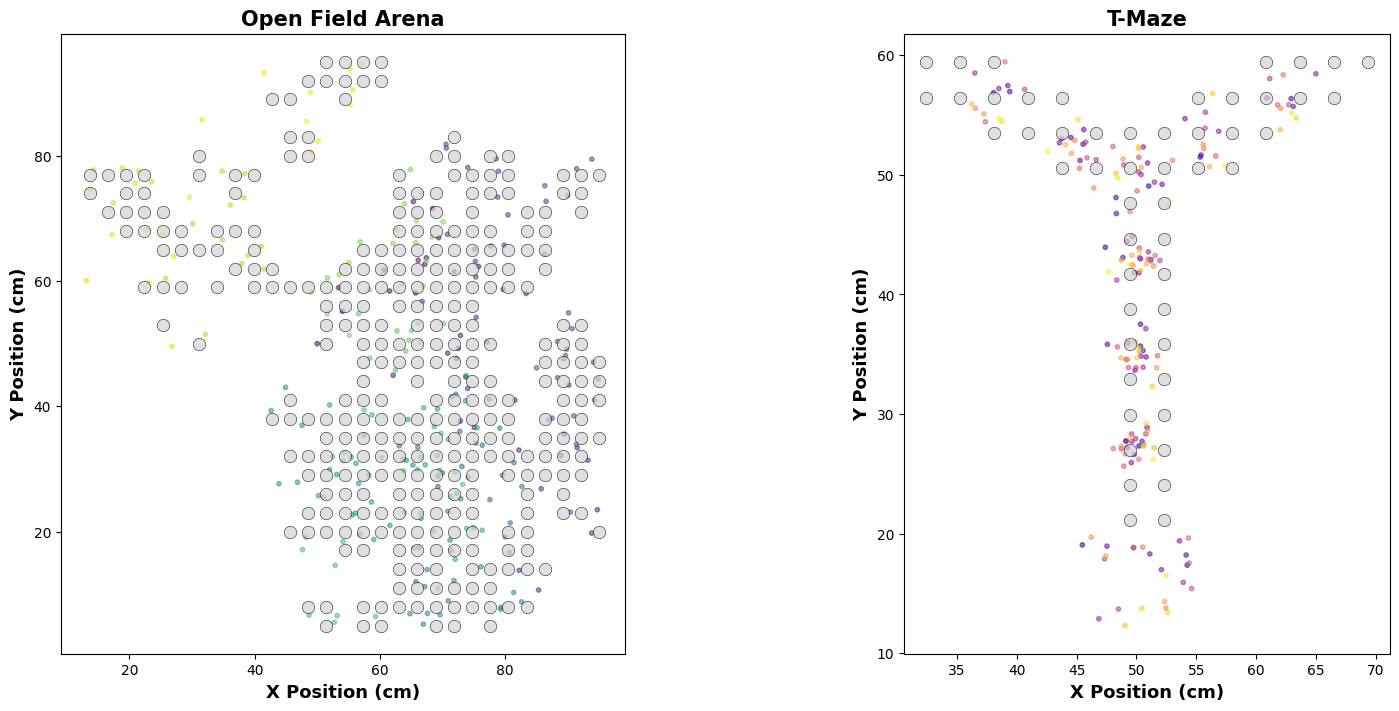

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), constrained_layout=True)

# Open field trajectory
axes[0].scatter(
    positions[::20, 0],
    positions[::20, 1],
    c=np.arange(len(positions[::20])),
    cmap="viridis",
    s=10,
    alpha=0.5,
)
axes[0].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c="lightgray",
    s=80,
    edgecolors="black",
    linewidths=0.5,
    alpha=0.7,
)
axes[0].set_xlabel("X Position (cm)", fontsize=13, fontweight="bold")
axes[0].set_ylabel("Y Position (cm)", fontsize=13, fontweight="bold")
axes[0].set_title("Open Field Arena", fontsize=15, fontweight="bold")
axes[0].set_aspect("equal")

# T-maze trajectory
axes[1].scatter(
    tmaze_positions[::10, 0],
    tmaze_positions[::10, 1],
    c=np.arange(len(tmaze_positions[::10])),
    cmap="plasma",
    s=10,
    alpha=0.5,
)
axes[1].scatter(
    tmaze_env.bin_centers[:, 0],
    tmaze_env.bin_centers[:, 1],
    c="lightgray",
    s=80,
    edgecolors="black",
    linewidths=0.5,
    alpha=0.7,
)
axes[1].set_xlabel("X Position (cm)", fontsize=13, fontweight="bold")
axes[1].set_ylabel("Y Position (cm)", fontsize=13, fontweight="bold")
axes[1].set_title("T-Maze", fontsize=15, fontweight="bold")
axes[1].set_aspect("equal")

plt.show()

### Simulate Place Cell in T-Maze

This place cell will remap - it had a field at (60, 50) in the open field. In the T-maze, we'll give it a field at (35, 58) (left arm).

In [13]:
# Generate spikes for T-maze (place field in left arm)
tmaze_field_center = np.array([35.0, 58.0])  # Left arm
tmaze_sigma = 8.0  # cm
tmaze_peak_rate = 12.0  # Hz (slightly higher rate in T-maze)

# Compute firing probability
tmaze_distances = np.linalg.norm(tmaze_positions - tmaze_field_center, axis=1)
tmaze_firing_rate_continuous = tmaze_peak_rate * np.exp(
    -(tmaze_distances**2) / (2 * tmaze_sigma**2)
)

# Generate spikes
tmaze_dt = np.mean(np.diff(tmaze_times))
tmaze_spike_probs = tmaze_firing_rate_continuous * tmaze_dt
tmaze_spike_mask = np.random.rand(len(tmaze_times)) < tmaze_spike_probs
tmaze_spike_times = tmaze_times[tmaze_spike_mask]

print(f"\nGenerated {len(tmaze_spike_times)} spikes in T-maze")
print(f"T-maze field center: {tmaze_field_center}")

# Compute firing rate map for T-maze
tmaze_firing_rate = compute_place_field(
    tmaze_env,
    tmaze_spike_times,
    tmaze_times,
    tmaze_positions,
    bandwidth=5.0,
)


Generated 193 spikes in T-maze
T-maze field center: [35. 58.]


### Visualize Remapping: Same Cell, Two Environments

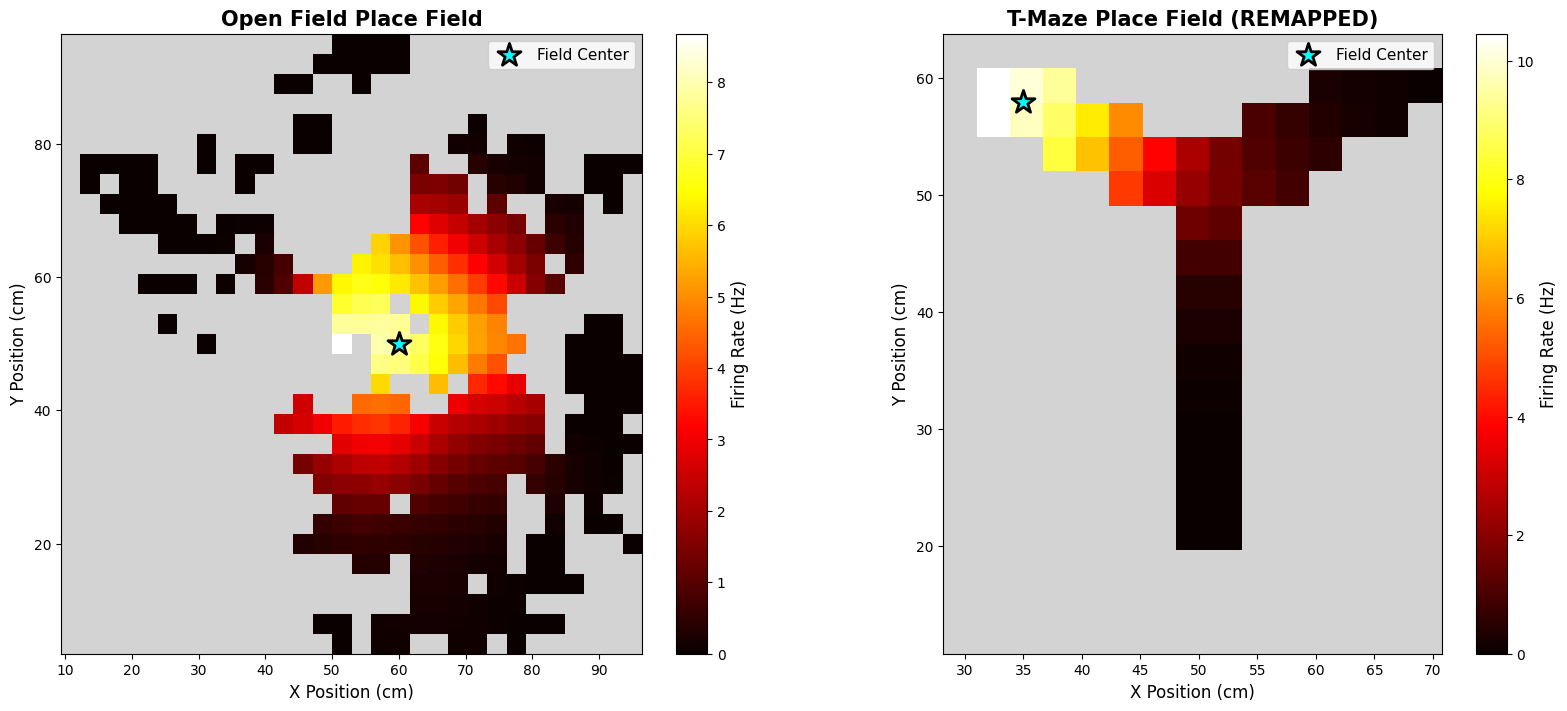


REMAPPING DETECTED
Open field center: [60. 50.]
T-maze center:     [35. 58.]
Distance moved:    26.2 cm

This demonstrates GLOBAL REMAPPING - the place field
completely reorganized in the new environment!


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), constrained_layout=True)

# Open field place field
env.plot_field(
    firing_rate,
    ax=axes[0],
    cmap="hot",
    vmin=0,
    colorbar_label="Firing Rate (Hz)",
)
axes[0].scatter(
    field_center[0],
    field_center[1],
    s=300,
    c="cyan",
    marker="*",
    edgecolors="black",
    linewidths=2,
    label="Field Center",
    zorder=10,
)
axes[0].set_title("Open Field Place Field", fontsize=15, fontweight="bold")
axes[0].legend(fontsize=11)

# T-maze place field
tmaze_env.plot_field(
    tmaze_firing_rate,
    ax=axes[1],
    cmap="hot",
    vmin=0,
    colorbar_label="Firing Rate (Hz)",
)
axes[1].scatter(
    tmaze_field_center[0],
    tmaze_field_center[1],
    s=300,
    c="cyan",
    marker="*",
    edgecolors="black",
    linewidths=2,
    label="Field Center",
    zorder=10,
)
axes[1].set_title("T-Maze Place Field (REMAPPED)", fontsize=15, fontweight="bold")
axes[1].legend(fontsize=11)

plt.show()

print("\n" + "=" * 60)
print("REMAPPING DETECTED")
print("=" * 60)
print(f"Open field center: {field_center}")
print(f"T-maze center:     {tmaze_field_center}")
print(f"Distance moved:    {np.linalg.norm(field_center - tmaze_field_center):.1f} cm")
print("\nThis demonstrates GLOBAL REMAPPING - the place field")
print("completely reorganized in the new environment!")

### Quantify Remapping with Spatial Correlation

We can't directly compare firing rates between different environments (different bin positions). Instead, we use **spatial correlation** by interpolating one map onto the other's coordinates.

For environments with overlapping spatial extent, we can:
1. Find bins that exist in both environments
2. Interpolate firing rates to common positions
3. Compute correlation

**Note**: For very different geometries (like open field vs T-maze), spatial correlation is less meaningful. Population vector correlation (across multiple cells) is more appropriate.

In [15]:
def compute_spatial_correlation_overlap(env1, rate1, env2, rate2):
    """
    Compute spatial correlation for overlapping region of two environments.

    This is a simplified approach - finds bins in env2 closest to env1 bins
    within a distance threshold.
    """
    from scipy.spatial.distance import cdist

    # Find overlapping bins (bins in env1 close to bins in env2)
    distances = cdist(env1.bin_centers, env2.bin_centers)

    # For each bin in env1, find closest bin in env2
    closest_env2_bins = np.argmin(distances, axis=1)
    min_distances = np.min(distances, axis=1)

    # Only use bins within 5 cm (approximately overlapping)
    overlap_threshold = 5.0  # cm
    overlap_mask = min_distances < overlap_threshold

    if overlap_mask.sum() < 5:
        return np.nan, 0

    # Get firing rates for overlapping bins
    rate1_overlap = rate1[overlap_mask]
    rate2_overlap = rate2[closest_env2_bins[overlap_mask]]

    # Remove NaN values
    valid = ~np.isnan(rate1_overlap) & ~np.isnan(rate2_overlap)

    if valid.sum() < 5:
        return np.nan, valid.sum()

    # Compute correlation
    corr = np.corrcoef(rate1_overlap[valid], rate2_overlap[valid])[0, 1]

    return corr, valid.sum()


# Compute spatial correlation
spatial_corr, n_overlap = compute_spatial_correlation_overlap(
    env, firing_rate, tmaze_env, tmaze_firing_rate
)

print("\nSpatial Correlation (Remapping Metric):")
print(f"  Correlation: {spatial_corr:.3f}")
print(f"  Overlapping bins: {n_overlap}")
print("\nInterpretation:")
print("  > 0.7: Same place field (stable)")
print("  0.3-0.7: Partial remapping")
print("  < 0.3: Complete remapping (this cell)")


Spatial Correlation (Remapping Metric):
  Correlation: -0.322
  Overlapping bins: 65

Interpretation:
  > 0.7: Same place field (stable)
  0.3-0.7: Partial remapping
  < 0.3: Complete remapping (this cell)


## Summary

In this notebook, we demonstrated:

1. **Firing Rate Computation**: Converting spike trains to spatial maps with occupancy normalization
2. **Place Field Detection**: Automatic identification using peak-based segmentation
3. **Field Properties**: Computing size and centroid for each field
4. **Spatial Metrics**: Skaggs information and sparsity for quantifying spatial coding
5. **Stability Analysis**: Split-half correlation to assess field reliability
6. **Complete Workflow**: End-to-end analysis function
7. **T-Maze Analysis**: Working with irregular environments
8. **Place Remapping**: Quantifying how place fields change between environments

### Key Functions Used

- `compute_place_field()` - Spike train → firing rate map
- `detect_place_fields()` - Automatic field detection
- `field_size()` - Field area in physical units
- `field_centroid()` - Center of mass
- `skaggs_information()` - Spatial information (bits/spike)
- `sparsity()` - Firing sparsity [0, 1]
- `field_stability()` - Temporal stability (correlation)

### References

- O'Keefe & Dostrovsky (1971): Discovery of place cells
- Skaggs et al. (1993): Spatial information metric
- Skaggs et al. (1996): Sparsity metric
- Muller & Kubie (1987, 1989): Place field characterization
- Wilson & McNaughton (1993): Population dynamics

### Next Steps

- Try with real experimental data
- Analyze populations of place cells (see population metrics)
- Compare place fields across conditions
- Analyze boundary cells (see boundary cell notebook)